In [104]:
import numpy as np
import json as js
import matplotlib.pyplot as plt
import matplotlib.ticker as mtk
import matplotlib.colors as clr
from matplotlib.collections import LineCollection

In [64]:
with open("../build-Cpplib-Desktop_Qt_6_3_1_GCC_64bit-Debug/tests/mesh_tests/mesh_vis.json") as file_ice, \
     open("../build-Cpplib-Desktop_Qt_6_3_1_GCC_64bit-Debug/tests/mesh_tests/mesh_vis.json") as file_snow:
    obj_ice = js.load(file_ice)
    obj_snow = js.load(file_snow)

In [75]:
def get_Z_pair(dzi, dzs, rho_i, rho_s, rho_w):
    
    bottomline = (-np.dot(dzi, rho_i) - np.dot(dzs, rho_s))/rho_w
    
    Z_i = np.concatenate(([bottomline], dzi)).cumsum()
    Z_i = np.append(Z_i, Z_i[[-1]])
    Z_i[1:-1] -= [dz/2 for dz in dzi]
    
    Z_s = np.concatenate((Z_i[[-1]], dzs)).cumsum()
    Z_s = np.append(Z_s, Z_s[[-1]])
    Z_s[1:-1] -= [dz/2 for dz in dzs]
    
    return Z_i, Z_s

In [78]:
def truncate_colormap(cmap, minval=0.0, maxval=1.0, n=100):
    new_cmap = clr.LinearSegmentedColormap.from_list(
        'trunc({n},{a:.2f},{b:.2f})'.format(n=cmap.name, a=minval, b=maxval),
        cmap(np.linspace(minval, maxval, n)))
    return new_cmap

In [106]:
def plot_snap(Z_i_list, Z_s_list, T_i_list, T_s_list, 
              figsize=(15, 10),
              t_min=None, t_max=None,
              cmap=None, names=None,
              savepath=None, dpi=None):
    
    z_min = min([Z_i[0] for Z_i in Z_i_list])
    z_max = max([Z_s[-1] for Z_s in Z_s_list])
    t_min = min(map(min, T_i_list + T_s_list)) if t_min is None else t_min
    t_max = max(map(max, T_i_list + T_s_list)) if t_max is None else t_max
#     temp_pairs = [min(T_i + T_s), max(T) for T in T_list]

    cmaps = ['Blues', 'Purples', 'Greens', 'cool', 'winter']
    lines_ice = []

    fig, axes = plt.subplots(nrows=len(T_i_list) + 1, figsize=figsize, \
                             gridspec_kw={"height_ratios": [1] + [0.05]*len(T_i_list)})
    ax = axes[0]
    ax.set_xlim(t_min - (t_max - t_min)*0.1, t_max + (t_max - t_min)*0.1)
    ax.set_ylim(z_min - (z_max - z_min)*0.1, z_max + (z_max - z_min)*0.1)
    for i, (Z_i, Z_s, T_i, T_s) in enumerate(zip(Z_i_list, Z_s_list, T_i_list, T_s_list)):
        norm = plt.Normalize(max(min(T_i + T_s), t_min), min(max(T_i + T_s), t_max))
        cmap = truncate_colormap(plt.get_cmap(cmaps[i%len(cmaps)]), 0.3, 1)
        
        points_ice = [(T, Z) for T, Z in zip(T_i, Z_i)]
        segments_ice = [segment for segment in zip(points_ice[:-1], points_ice[1:])]
        lc = LineCollection(segments_ice, linewidths=3, cmap=cmap, norm=norm)
        lc.set_array(T_i)
        line_ice = ax.add_collection(lc)
        lines_ice.append(line_ice)
        
        markers = ax.scatter(T_i, Z_i, s=60)
        markers.set_cmap(cmap)
        markers.set_array(T_i)

        ax.plot(T_s, Z_s, color='grey', lw=3, marker='o')
        
    ax.axhline(ls='--', lw=3, color='navy')
    ax.set_xlabel(r'T, $^o C$', size=20)
    ax.set_ylabel('Z, m', size=20)
    ax.yaxis.set_major_formatter(mtk.FormatStrFormatter('%.2f'))
    ax.tick_params(labelsize=15)
    ax.grid()
    
    for i, (cax, line_ice) in enumerate(zip(axes[1:], lines_ice)):
        cbar = fig.colorbar(line_ice, cax=cax, orientation='horizontal')
        if names is None:
            cbar.ax.set_xlabel('process %d'%i, size=20)
        else:
            cbar.ax.set_xlabel(names[i], size=20)
        cbar.ax.tick_params(labelsize=15)
    
    if savepath is None:
        plt.show()
    else:
        fig.savefig(fig, savepath)

In [86]:
plt.Figure.savefig()

{'cells data': {'cells_density_array': [917.0,
   917.0,
   917.0,
   917.0,
   917.0,
   917.0,
   917.0,
   917.0,
   917.0,
   917.0,
   917.0,
   917.0,
   917.0,
   917.0,
   917.0],
  'cells_temp_array': [-5.0,
   -5.333333333333333,
   -5.666666666666667,
   -6.0,
   -6.333333333333333,
   -6.666666666666666,
   -7.0,
   -7.333333333333334,
   -7.666666666666666,
   -8.0,
   -8.333333333333332,
   -8.666666666666666,
   -9.0,
   -9.333333333333334,
   -9.666666666666668]},
 'cells_thickness_array': [0.26666666666666666,
  0.26666666666666666,
  0.26666666666666666,
  0.26666666666666666,
  0.26666666666666666,
  0.26666666666666666,
  0.26666666666666666,
  0.26666666666666666,
  0.26666666666666666,
  0.26666666666666666,
  0.26666666666666666,
  0.26666666666666666,
  0.26666666666666666,
  0.26666666666666666,
  0.26666666666666666],
 'single data': {'down_temp': -5.0, 'up_temp': -10.0}}

In [94]:
Z_i, Z_s = get_Z_pair(obj_ice["cells_thickness_array"], obj_snow["cells_thickness_array"],
                      obj_ice["cells data"]["cells_density_array"], obj_snow["cells data"]["cells_density_array"],
                      1023.0)

In [91]:
T_i = [obj_ice["single data"]["down_temp"]] + obj_ice["cells data"]["cells_temp_array"]\
    + [obj_ice["single data"]["up_temp"]]
T_s = [obj_snow["single data"]["down_temp"]] + obj_snow["cells data"]["cells_temp_array"]\
    + [obj_snow["single data"]["up_temp"]]

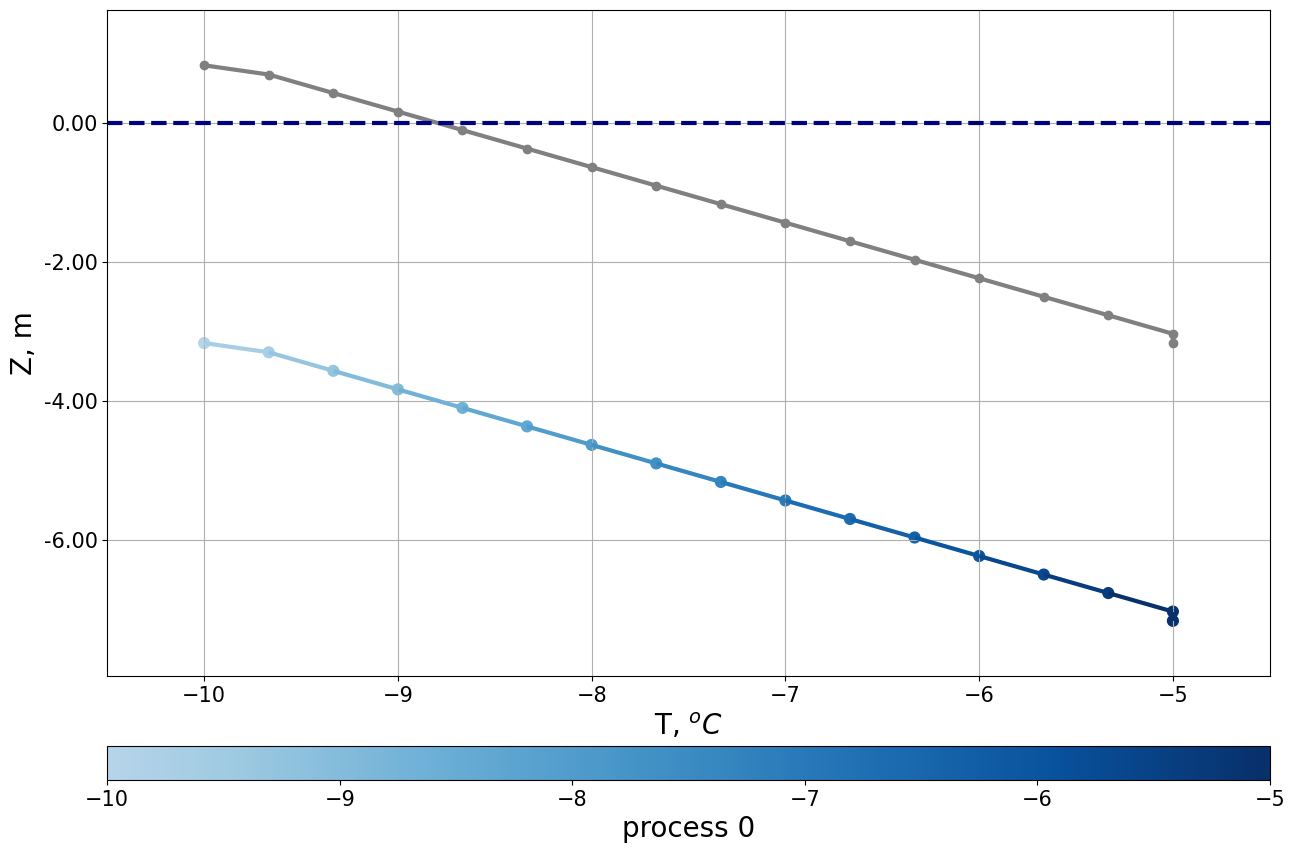

In [107]:
plot_snap([Z_i], [Z_s], [T_i], [T_s])